# setup

In [1]:
import os

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
import torch
import torch.nn as nn
import neurokit2 as nk

from tqdm import tqdm

from models.baseline import ResnetBaseline
from runners.train import Runner

In [3]:
from dataloaders.code_draft import CODE as DS
from dataloaders.code_draft import CODEsplit as DSsplit

# init

In [4]:
database = DS()
model = ResnetBaseline(n_classes = 6)
model = torch.load('output/code/code.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
runner = Runner(device = device, model = model, database = database, split = DSsplit, model_label = 'code')

using test ds, H is treated as X


# utils

In [6]:
SIGNAL_CROP_LEN = 2560
SIGNAL_NON_ZERO_START = 571

# def get_inputs(batch, apply = "non_zero", device = "cuda"):
def get_inputs(batch, apply = "nothing", device = "cuda"):
    # (B, C, L)
    if batch.shape[1] > batch.shape[2]:
        batch = batch.permute(0, 2, 1)

    B, n_leads, signal_len = batch.shape

    if apply == "non_zero":
        transformed_data = torch.zeros(B, n_leads, SIGNAL_CROP_LEN)
        for b in range(B):
            start = SIGNAL_NON_ZERO_START
            diff = signal_len - start
            if start > diff:
                correction = start - diff
                start -= correction
            end = start + SIGNAL_CROP_LEN
            for l in range(n_leads):
                transformed_data[b, l, :] = batch[b, l, start:end]

    else:
        transformed_data = batch.float()

    return transformed_data.to(device)

In [7]:
from sklearn.metrics import f1_score

def find_best_thresholds(predictions, true_labels_dict, thresholds):
    num_classes = len(predictions[0])
    best_thresholds = [0.5] * num_classes
    best_f1s = [0.0] * num_classes

    for class_idx in (range(num_classes)):
        for thresh in thresholds:
            f1 = f1_score(
                true_labels_dict[class_idx],
                predictions[thresh][class_idx],
                zero_division=0,
            )

            if f1 > best_f1s[class_idx]:
                best_f1s[class_idx] = f1
                best_thresholds[class_idx] = thresh
    
    return best_f1s, best_thresholds

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def metrics_table(all_binary_results, all_true_labels):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []

    num_classes = all_binary_results.shape[-1]
    for class_idx in range(num_classes):
        class_binary_results = all_binary_results[:, class_idx].cpu().numpy()
        class_true_labels = all_true_labels[:, class_idx].cpu().numpy()

        accuracy = accuracy_score(class_true_labels, class_binary_results)
        precision = precision_score(class_true_labels, class_binary_results, zero_division=0)
        recall = recall_score(class_true_labels, class_binary_results, zero_division=0)
        f1 = f1_score(class_true_labels, class_binary_results, zero_division=0)
        auc = roc_auc_score(class_true_labels, class_binary_results)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auc_scores.append(auc)
    
    # normal
    # normal_idx = torch.sum(all_true_labels, dim = 1) == 0
    
    # class_binary_results = torch.sum(all_binary_results, axis = 1).bool()[normal_idx].cpu().numpy()
    # class_true_labels = torch.sum(all_true_labels, axis = 1).bool()[normal_idx].cpu().numpy()
    class_binary_results = (~torch.sum(all_binary_results, axis = 1).bool()).int().cpu().numpy()
    class_true_labels = (~torch.sum(all_true_labels, axis = 1).bool()).int().cpu().numpy()

    accuracy = accuracy_score(class_true_labels, class_binary_results)
    precision = precision_score(class_true_labels, class_binary_results, zero_division=0)
    recall = recall_score(class_true_labels, class_binary_results, zero_division=0)
    f1 = f1_score(class_true_labels, class_binary_results, zero_division=0)
    auc = roc_auc_score(class_true_labels, class_binary_results)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_scores.append(auc)

    metrics_dict = {
        "Accuracy": accuracy_scores,
        # "Precision": precision_scores,
        # "Recall": recall_scores,
        "F1 Score": f1_scores,
        "AUC ROC": auc_scores,
    }

    return metrics_dict

# eval

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from hparams import BATCH_SIZE, NUM_WORKERS

In [10]:
model = model.to(device)
val_dl = torch.utils.data.DataLoader(runner.val_ds, batch_size = BATCH_SIZE, 
                                        shuffle = False, num_workers = NUM_WORKERS)
tst_dl = torch.utils.data.DataLoader(runner.tst_ds, batch_size = BATCH_SIZE, 
                                        shuffle = False, num_workers = NUM_WORKERS)
best_f1s, best_thresholds = runner._synthesis(val_dl, best_thresholds = None)
all_binary_results, all_true_labels, metrics_dict = runner._synthesis(tst_dl, best_thresholds)

100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


In [11]:
metrics_dict

{'Accuracy': [0.9903264812575574,
  0.9939540507859734,
  0.9987908101571947,
  0.9915356711003628,
  0.9963724304715841,
  0.9939540507859734,
  0.9746070133010882],
 'F1 Score': [0.8518518518518519,
  0.9275362318840579,
  0.983050847457627,
  0.8108108108108109,
  0.8695652173913044,
  0.9315068493150684,
  0.9845928099779897],
 'AUC ROC': [0.9088369390309315,
  0.9686966842222386,
  0.9833333333333334,
  0.9650508631319359,
  0.8846153846153846,
  0.9581936366746493,
  0.9549866232172671]}

In [ ]:
model = model.to(device)
tst_dl = torch.utils.data.DataLoader(runner.tst_ds, batch_size = 827, 
                                        shuffle = False, num_workers = NUM_WORKERS)
for batch in (tst_dl):
    raw = batch['X']
    label = batch['y']
    ecg = get_inputs(raw, device = 'cpu')
    label = label.float()

In [ ]:
error_idx = torch.sum((all_binary_results != all_true_labels).cpu(), axis = 1).bool()

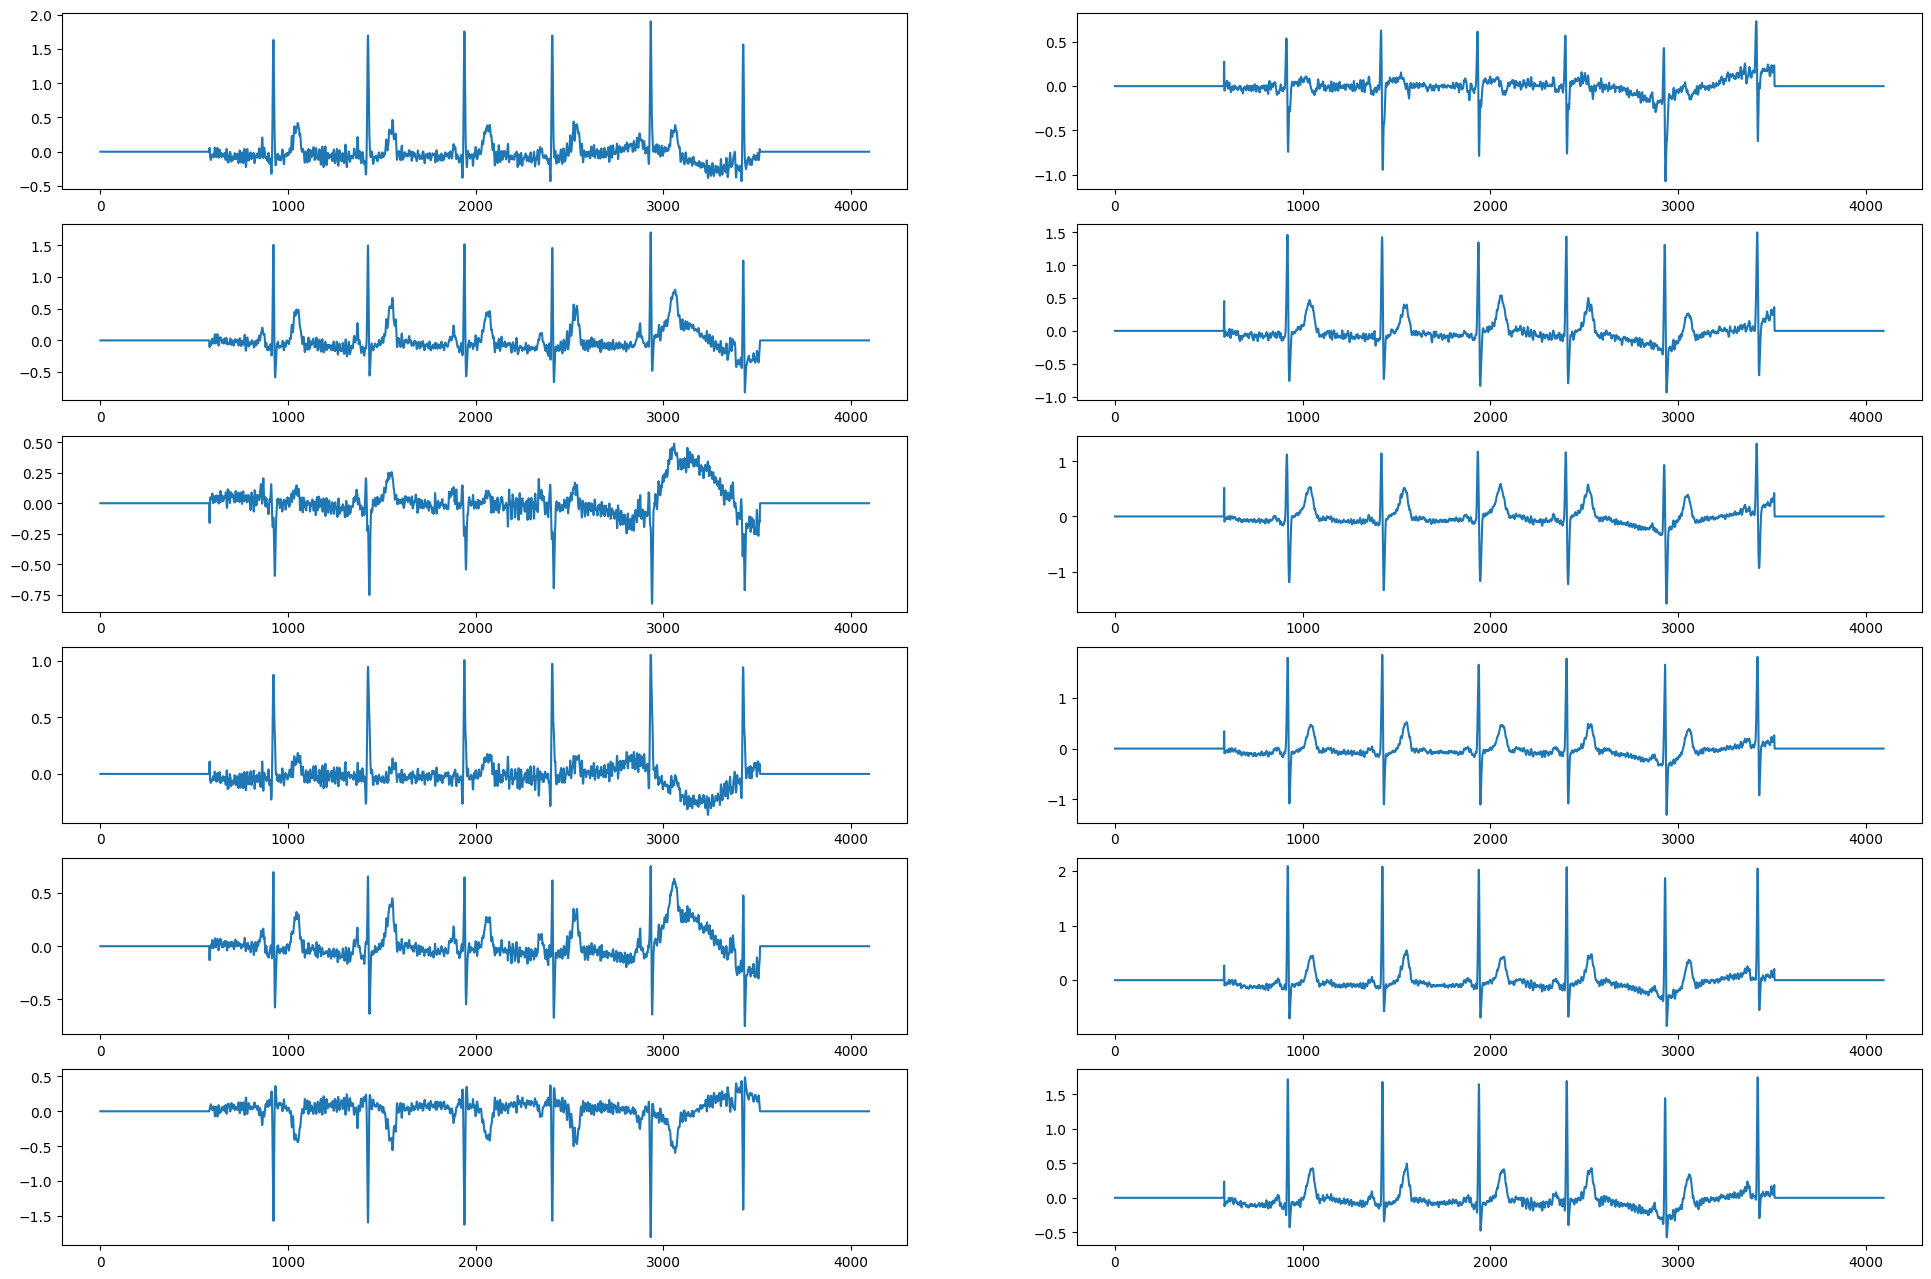

In [ ]:
erros = ecg[error_idx]

s = 0
erro = erros[s, :, :]
fig, axs = plt.subplots(6, 2, figsize = (24, 16))
for ii in range(12):
    i = ii % 6
    j = ii // 6
    axs[i, j].plot(erro[ii, :]);

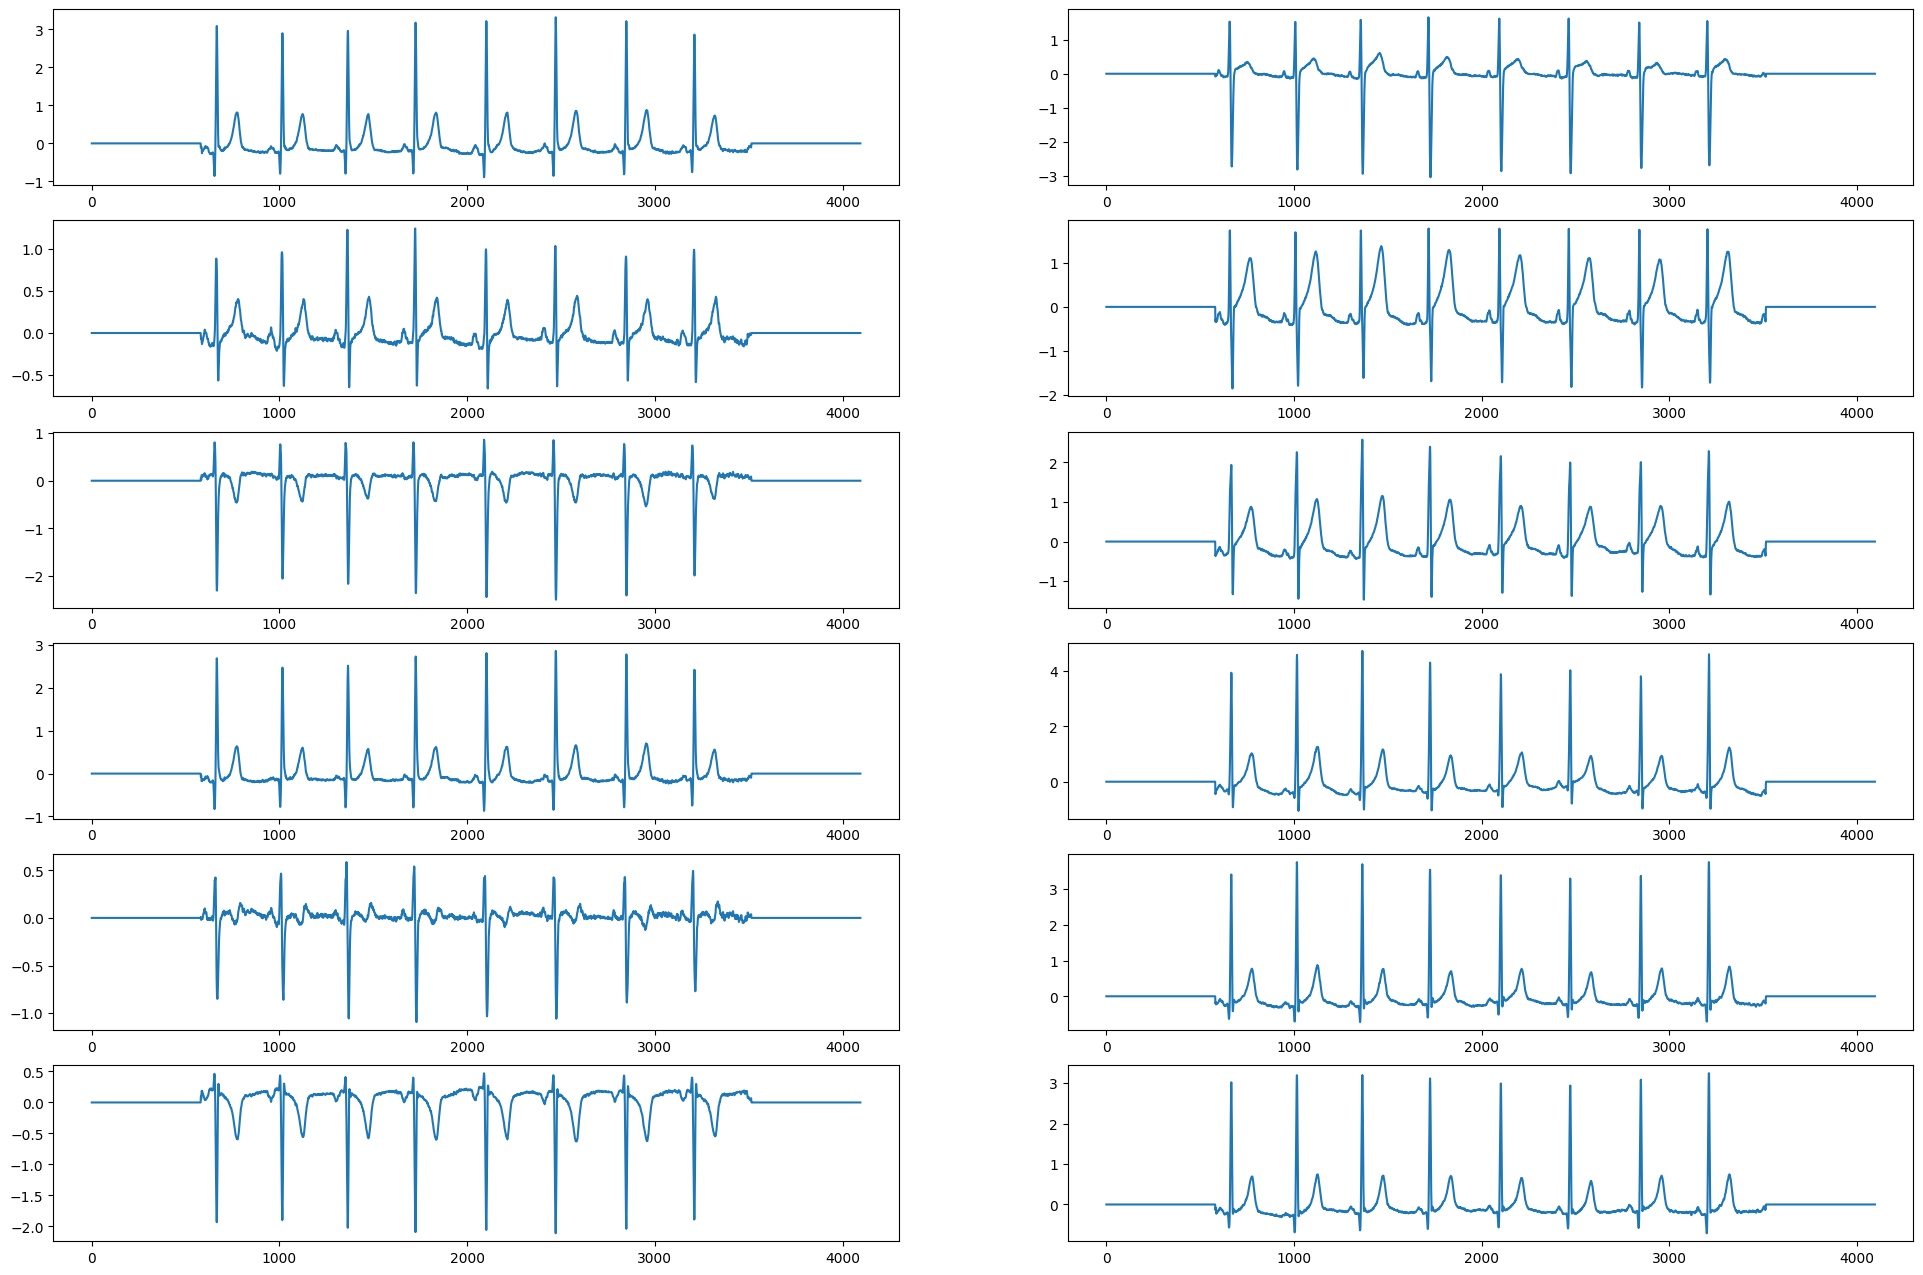

In [ ]:
acertos = ecg[~error_idx]

s = 0
acerto = acertos[s, :, :]
fig, axs = plt.subplots(6, 2, figsize = (24, 16))
for ii in range(12):
    i = ii % 6
    j = ii // 6
    axs[i, j].plot(acerto[ii, :]);

# filtro

In [ ]:
fs = 400

In [ ]:
clean = nk.ecg_clean(erro[0, :], sampling_rate = fs)

In [ ]:
erro.shape

torch.Size([12, 4096])

In [ ]:
clean.shape

(4096,)

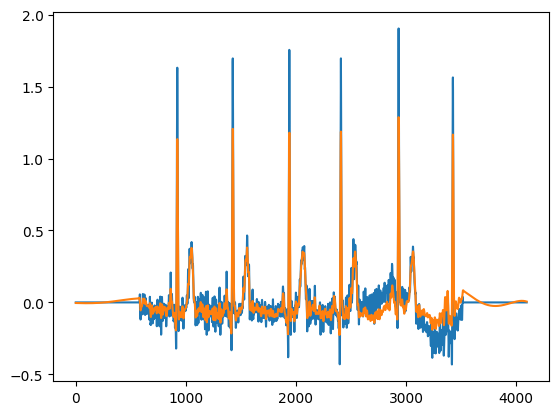

In [ ]:
plt.plot(erro[0, :]);
plt.plot(nk.ecg_clean(erro[0, :], sampling_rate = fs));

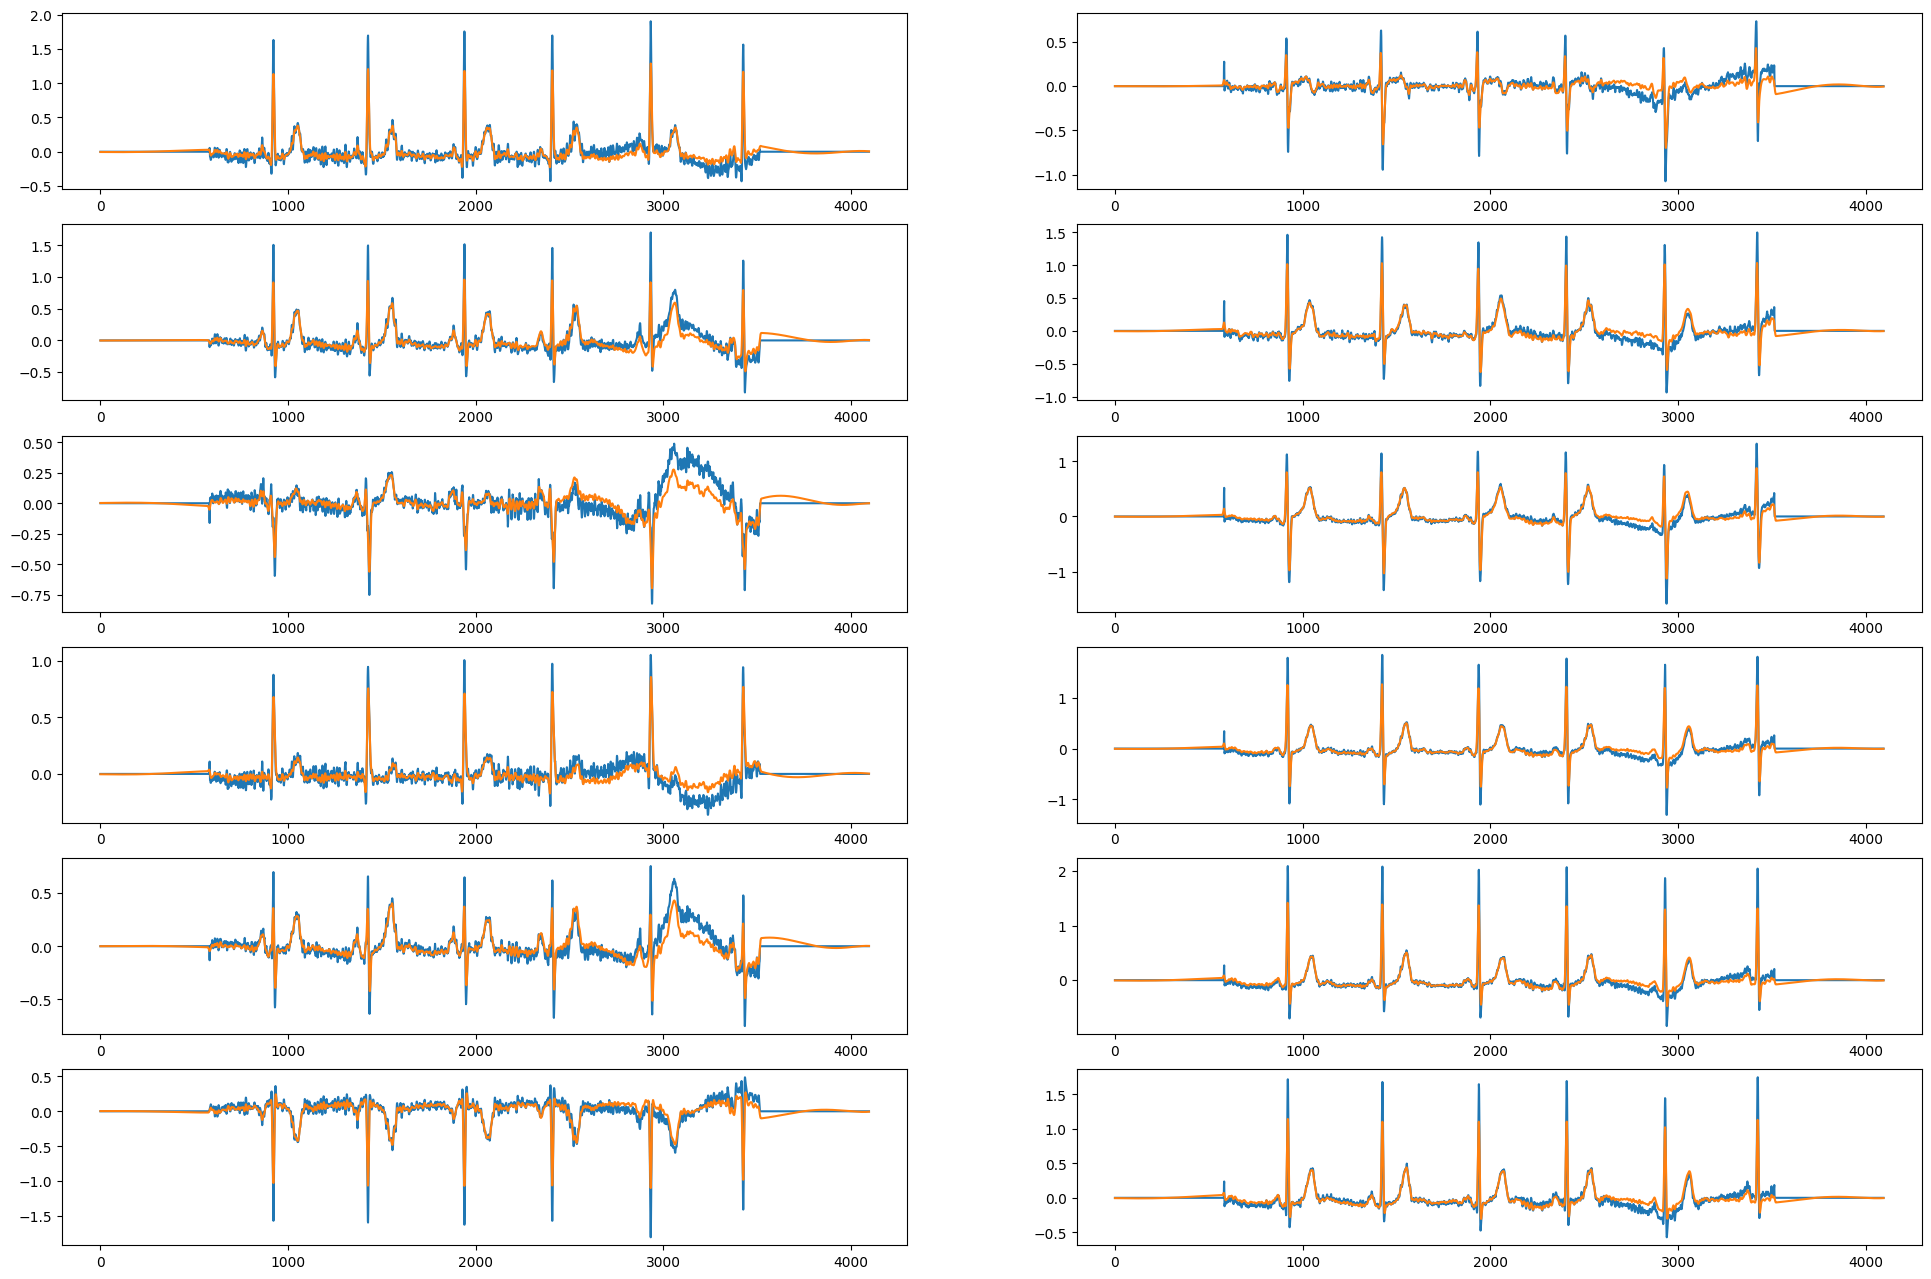

In [ ]:
erros = ecg[error_idx]

s = 0
erro = erros[s, :, :]
fig, axs = plt.subplots(6, 2, figsize = (24, 16))
for ii in range(12):
    i = ii % 6
    j = ii // 6
    axs[i, j].plot(erro[ii, :]);
    axs[i, j].plot(nk.ecg_clean(erro[ii, :], sampling_rate = fs));

# nk tst

In [16]:
def get_inputs(batch, method = 'neurokit', device = "cuda"):
    # (B, C, L)
    if batch.shape[1] > batch.shape[2]:
        batch = batch.permute(0, 2, 1)
    
    fs = 400
    for i in (range(batch.shape[0])):
        for j in range(batch.shape[1]):
            batch[i, j, :] = torch.tensor(nk.ecg_clean(batch[i, j, :], sampling_rate = fs, method = method).copy())

    transformed_data = batch.float()
    return transformed_data.to(device)

In [17]:
def synthesis(model, device, loader, best_thresholds, method = 'neurokit'):
    all_binary_results = []
    all_true_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader):
            # raw, exam_id, label = batch
            raw = batch['X']
            label = batch['y']
            ecg = get_inputs(raw, device = device, method = method)
            label = label.to(device).float()

            logits = model(ecg)
            probs = torch.sigmoid(logits)

            binary_result = torch.zeros_like(probs)
            for i in range(len(best_thresholds)):
                binary_result[:, i] = (
                    probs[:, i] >= best_thresholds[i]
                ).float()
            
            all_binary_results.append(binary_result)
            all_true_labels.append(label)
    
    all_binary_results = torch.cat(all_binary_results, dim=0)
    all_true_labels = torch.cat(all_true_labels, dim=0)
    return all_binary_results, all_true_labels, metrics_table(all_binary_results, all_true_labels)

## neurokit

In [14]:
_, _, metrics_dict_neurokit = synthesis(model, device, tst_dl, best_thresholds, method = 'neurokit')
metrics_dict_neurokit

100%|██████████| 59/59 [00:00<00:00, 59.66it/s]


{'Accuracy': [0.992744860943168,
  0.9939540507859734,
  0.9987908101571947,
  0.9915356711003628,
  0.9963724304715841,
  0.992744860943168,
  0.9746070133010882],
 'F1 Score': [0.888888888888889,
  0.9275362318840579,
  0.983050847457627,
  0.8205128205128205,
  0.8695652173913044,
  0.9166666666666667,
  0.9845928099779897],
 'AUC ROC': [0.9273198641158591,
  0.9686966842222386,
  0.9833333333333334,
  0.9956843403205919,
  0.8846153846153846,
  0.9446801231611358,
  0.9549866232172671]}

## biosppy

In [15]:
_, _, metrics_dict_biosppy = synthesis(model, device, tst_dl, best_thresholds, method = 'biosppy')
metrics_dict_biosppy

100%|██████████| 59/59 [00:03<00:00, 17.15it/s]


{'Accuracy': [0.9903264812575574,
  0.9939540507859734,
  0.9987908101571947,
  0.992744860943168,
  0.9963724304715841,
  0.9939540507859734,
  0.9746070133010882],
 'F1 Score': [0.8518518518518519,
  0.9275362318840579,
  0.983050847457627,
  0.8421052631578948,
  0.8695652173913044,
  0.9315068493150684,
  0.9845928099779897],
 'AUC ROC': [0.9088369390309315,
  0.9686966842222386,
  0.9833333333333334,
  0.9963008631319359,
  0.8846153846153846,
  0.9581936366746493,
  0.9549866232172671]}

## pantompkins1985

In [18]:
_, _, metrics_dict_pantompkins1985 = synthesis(model, device, tst_dl, best_thresholds, method = 'pantompkins1985')
metrics_dict_pantompkins1985

100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


{'Accuracy': [0.9830713422007256,
  0.37968561064087064,
  0.9637243047158404,
  0.9939540507859734,
  0.992744860943168,
  0.9854897218863361,
  0.4486094316807739],
 'F1 Score': [0.75,
  0.07233273056057866,
  0.0,
  0.8571428571428572,
  0.7692307692307693,
  0.8125,
  0.5230125523012552],
 'AUC ROC': [0.8706195244055068,
  0.4794896521029598,
  0.5,
  0.966283908754624,
  0.8827726327726327,
  0.8507184399589462,
  0.5979371592943495]}

## hamilton2002

In [19]:
_, _, metrics_dict_hamilton2002 = synthesis(model, device, tst_dl, best_thresholds, method = 'hamilton2002')
metrics_dict_hamilton2002

100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


{'Accuracy': [0.9685610640870617,
  0.9129383313180169,
  0.9637243047158404,
  0.9915356711003628,
  0.9915356711003628,
  0.9830713422007256,
  0.8778718258766627],
 'F1 Score': [0.13333333333333333,
  0.0,
  0.0,
  0.787878787878788,
  0.7199999999999999,
  0.7812500000000001,
  0.9286219081272084],
 'AUC ROC': [0.5357142857142857,
  0.4760403530895334,
  0.5,
  0.9037839087546239,
  0.8443110943110943,
  0.8365720150530277,
  0.7186802244885644]}

## elgendi2010

In [20]:
_, _, metrics_dict_elgendi2010 = synthesis(model, device, tst_dl, best_thresholds, method = 'elgendi2010')
metrics_dict_elgendi2010

100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


{'Accuracy': [0.966142684401451,
  0.932285368802902,
  0.9637243047158404,
  0.9891172914147521,
  0.9903264812575574,
  0.973397823458283,
  0.875453446191052],
 'F1 Score': [0.0,
  0.2820512820512821,
  0.0,
  0.7096774193548386,
  0.6,
  0.6071428571428572,
  0.927719298245614],
 'AUC ROC': [0.5,
  0.6409576440916845,
  0.5,
  0.841283908754624,
  0.7301549801549803,
  0.7284639069449196,
  0.7010691368454931]}

## engzeemod2012

In [21]:
_, _, metrics_dict_engzeemod2012 = synthesis(model, device, tst_dl, best_thresholds, method = 'engzeemod2012')
metrics_dict_engzeemod2012

100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


{'Accuracy': [0.9903264812575574,
  0.9939540507859734,
  0.9987908101571947,
  0.9915356711003628,
  0.9963724304715841,
  0.9939540507859734,
  0.9746070133010882],
 'F1 Score': [0.8518518518518519,
  0.9275362318840579,
  0.983050847457627,
  0.8108108108108109,
  0.8695652173913044,
  0.9315068493150684,
  0.9845928099779897],
 'AUC ROC': [0.9088369390309315,
  0.9686966842222386,
  0.9833333333333334,
  0.9650508631319359,
  0.8846153846153846,
  0.9581936366746493,
  0.9549866232172671]}

## vg

In [22]:
_, _, metrics_dict_vg = synthesis(model, device, tst_dl, best_thresholds, method = 'vg')
metrics_dict_vg

100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


{'Accuracy': [0.973397823458283,
  0.9431680773881499,
  0.973397823458283,
  0.9939540507859734,
  0.9879081015719468,
  0.992744860943168,
  0.9068923821039904],
 'F1 Score': [0.35294117647058826,
  0.5523809523809524,
  0.4210526315789474,
  0.8648648648648648,
  0.4444444444444444,
  0.9142857142857143,
  0.9438366156090444],
 'AUC ROC': [0.6071428571428571,
  0.8999888732289889,
  0.6333333333333333,
  0.9969173859432798,
  0.6532319032319032,
  0.9317995210400274,
  0.8277764367469274]}